In [1]:
import sys
import os
import gzip
from optparse import OptionParser
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import pearsonr, spearmanr, linregress
from statsmodels.formula.api import ols
from matplotlib.lines import Line2D

%matplotlib inline

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
## Sample information
data_folder = "../data/LCR_lib_HBG_6LP/"
figure_folder = "../figures/"
reps = ["rep1", "rep2", "rep3"]
bins = ["bin1", "bin2", "bin3", "bin4"]
LPs = ["0kb","3kb", "10kb", "20kb", "50kb", "100kb"]
n_reps = len(reps)
n_bins = len(bins)
sorting_gates = pd.read_csv(data_folder+"sorting_gate_info.txt", sep="\t")

In [4]:
## Read barcode reference
dBC_file = pd.read_csv("dBCs.txt", sep="\t", header=None)
eBC_file = pd.read_csv("pYWD15_eBCs.txt", sep="\t")
eBC_dict = {x:y for x,y in zip(eBC_file["eBC"].to_list(), eBC_file["name"].to_list())}
dBC_dict = {x:y for x,y in zip(dBC_file[1].to_list(), dBC_file[0].to_list())}

eBCs = list(set(eBC_dict))
dBCs = list(set(dBC_dict))

In [5]:
# Combine data across bins for each replicate
all_datas = []
for rep in reps:
    datas = []
    for bin in bins:
        sample = rep+"_"+bin
        sample_dir = data_folder+sample+"_barcode_summary.txt"
        datas.append(pd.read_csv(sample_dir, sep = "\t"))
    combined_data = pd.concat(
        objs=(iDF.set_index(["CRE", "LP", "rBC"]) for iDF in datas),
        axis=1, 
        join='outer'
    ).reset_index()
    combined_data.columns = ["CRE", "LP", "rBC"] + bins
    combined_data = combined_data.fillna(0)
    combined_data = combined_data[combined_data["LP"].isin(LPs)]
    combined_data = combined_data[~combined_data["CRE"].str.contains("core")]
    combined_data["sum"] = combined_data["bin1"] + combined_data["bin2"] + combined_data["bin3"] + combined_data["bin4"]
    combined_data["rep"] = rep
    all_datas.append(combined_data)

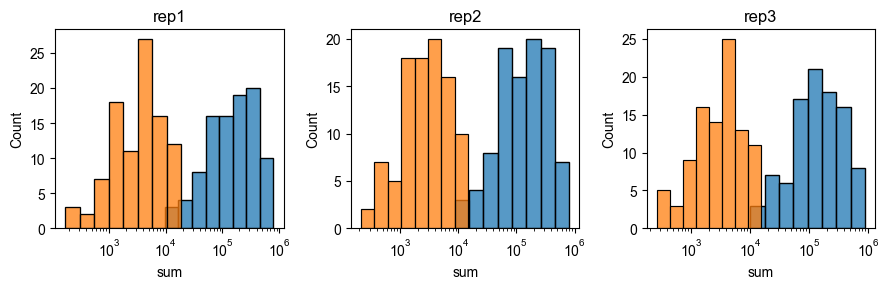

In [6]:
## Check read/rBC distribution across library members before any filtering
fig, axs = plt.subplots(ncols=n_reps, nrows=1, figsize=(3*n_reps, 3))
for ax, i in zip(axs, range(n_reps)):
    rep_data = all_datas[i]
    rep = reps[i]
    sns.histplot(data=rep_data.groupby(["CRE", "LP"])["sum"].sum(), log_scale=True, ax=ax)
    sns.histplot(data=rep_data.groupby(["CRE", "LP"])["rBC"].nunique(), log_scale=True, ax=ax)
    ax.set_title(rep)
plt.tight_layout()

In [7]:
## Check #integrations per distance
all_datas[0].groupby("LP")["rBC"].nunique()

LP
0kb       97150
100kb     43738
10kb      93428
20kb      45388
3kb      126812
50kb      24367
Name: rBC, dtype: int64

In [8]:
## Filter rBCs with too few read counts, or with template switching
s=20
filtered_datas = []
for data in all_datas:
    filtered_datas.append(data[data["sum"]>s].reset_index(drop=True).sort_values(by="sum", ascending=False).drop_duplicates(subset=["rBC", "CRE"], keep="first"))

In [9]:
## Calculate activity for each eBC-gBC
grouped_datas = []
for i in range(n_reps):
    rep = reps[i]
    filtered_data = filtered_datas[i]
    grouped_data = filtered_data.groupby(["CRE", "LP"])[[*bins, "sum"]].sum().reset_index()
    grouped_data["n_rBCs"] = filtered_data.groupby(["CRE", "LP"])["rBC"].nunique().reset_index()["rBC"]
    ### Normalize read counts by total number of reads in that bin
    for bin in bins:
        bin_percentage = sorting_gates[(sorting_gates["rep"] == rep) & (sorting_gates["bin"] == bin)]["percentage"].iloc[0]
        total_reads = grouped_data[bin].sum()
        grouped_data[bin+"_norm"] = grouped_data[bin]/total_reads
    ### Calculate weighted average across bins 
    grouped_data["norm_sum"] = 0
    for bin in bins:
        cell_percentage = sorting_gates[(sorting_gates["rep"] == rep) & (sorting_gates["bin"] == bin)]["percentage"].iloc[0]
        grouped_data["norm_sum"] = grouped_data["norm_sum"] + grouped_data[bin+"_norm"]*cell_percentage
    for bin in bins:
        cell_percentage = sorting_gates[(sorting_gates["rep"] == rep) & (sorting_gates["bin"] == bin)]["percentage"].iloc[0]
        grouped_data[bin+"_prop"] = grouped_data[bin+"_norm"]*cell_percentage / grouped_data["norm_sum"]
    grouped_data["exp"] = 0
    for bin in bins:
        MFI = sorting_gates[(sorting_gates["rep"] == rep) & (sorting_gates["bin"] == bin)]["MFI"].iloc[0]
        grouped_data["exp"] += MFI*grouped_data[bin+"_prop"]
    grouped_data["rep"] = rep
    grouped_datas.append(grouped_data)
    

In [10]:
## Combine data across replicates
combined_data = pd.concat(
    objs=(iDF.set_index(["CRE", "LP", "rep"]) for iDF in grouped_datas),
    join='inner'
).reset_index()
combined_data_wide = combined_data.pivot(index=["CRE", "LP"], columns = "rep", values = ["n_rBCs", "exp"])
combined_data_wide.columns = combined_data_wide.columns.map('_'.join)
combined_data_wide = combined_data_wide.reset_index()
## Calculate mean and std expression level across replicates

combined_data_wide["mean_exp"] = combined_data_wide.iloc[:,-n_reps:].mean(axis=1)
combined_data_wide["std_exp"] = combined_data_wide.iloc[:,-n_reps-1:-1].std(axis=1)
combined_data_wide["CV"] = combined_data_wide["std_exp"]/combined_data_wide["mean_exp"]
combined_data_wide["mean_n_rBCs"] = combined_data_wide.iloc[:, 2:2+n_reps].mean(axis=1)

<Figure size 500x500 with 0 Axes>

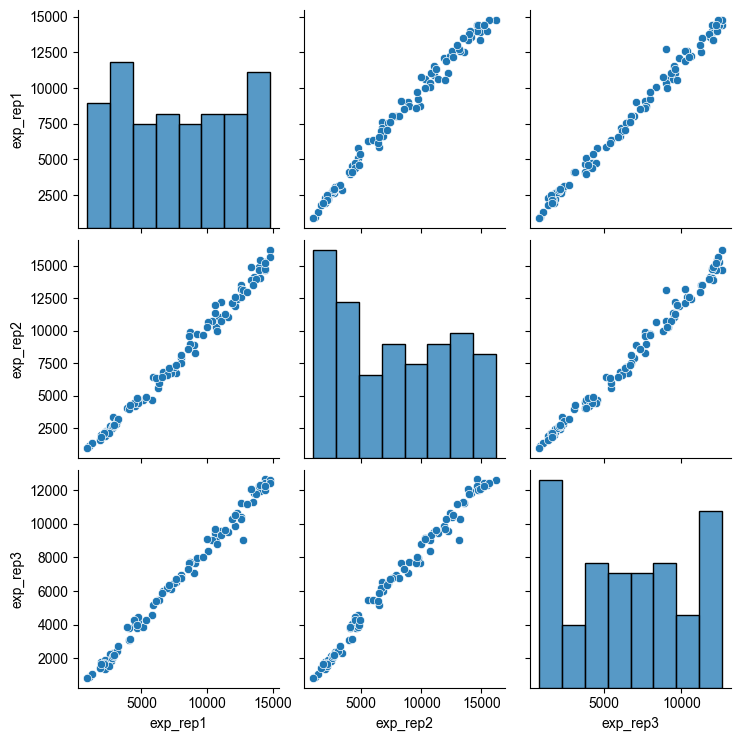

In [11]:
## Check reproducibility between replicates
plt.figure(figsize=(5,5))
sns.pairplot(data=combined_data_wide.iloc[:, -n_reps-4:-4])

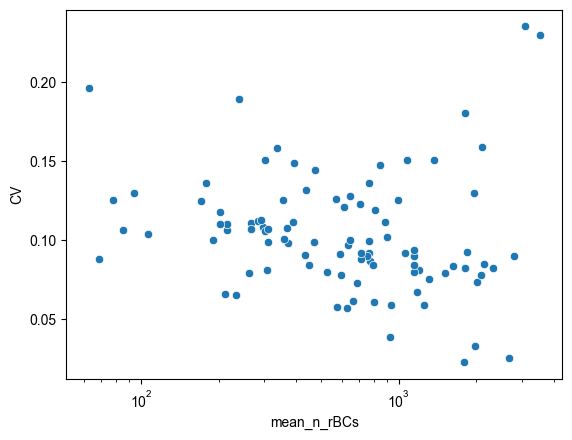

In [12]:
## Check relationship between number of rBCs and CV
sns.scatterplot(data=combined_data_wide, x="mean_n_rBCs", y="CV")
plt.xscale("log")

In [13]:
## Filter out elements with too fewer integrations
t = 10
filtered_combined_data_wide = combined_data_wide[combined_data_wide[["n_rBCs_rep1", "n_rBCs_rep2"]].min(axis=1)>t]

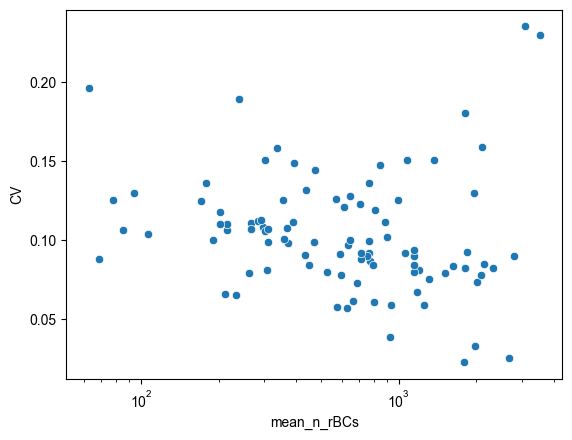

In [14]:
## Re-check relationship between number of rBCs and CV
sns.scatterplot(data=filtered_combined_data_wide, x="mean_n_rBCs", y="CV")
plt.xscale("log")

In [15]:
filtered_combined_data_wide_annotated = filtered_combined_data_wide

In [16]:
## Normalize activity by scrambled controls
for LP in LPs:
    mean_scrambled = filtered_combined_data_wide_annotated.loc[(filtered_combined_data_wide_annotated["CRE"] == "empty") & (filtered_combined_data_wide_annotated["LP"] == LP), "mean_exp"].mean()
    filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "norm_mean_exp"] = filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "mean_exp"]/mean_scrambled
    filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "norm_exp_rep1"] = filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "exp_rep1"]/mean_scrambled
    filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "norm_exp_rep2"] = filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "exp_rep2"]/mean_scrambled
    

In [17]:
filtered_CREs_combined_wide = filtered_combined_data_wide_annotated.pivot(index=["CRE"], columns="LP", values=["norm_mean_exp"])
filtered_CREs_combined_wide.columns = filtered_CREs_combined_wide.columns.map('_'.join)
filtered_CREs_combined_wide = filtered_CREs_combined_wide.dropna().reset_index()
filtered_combined_data_wide_annotated["distance"] = filtered_combined_data_wide_annotated["LP"].str.split("_").str[-1].str.strip("kb").astype(int)

In [18]:
## Normalize by basal promoter
for x in set(combined_data["CRE"].to_list()):
    for y in set(combined_data["LP"].to_list()):
        for z in ["rep1", "rep2", "rep3"]:
            row_index = ((combined_data["CRE"] == x) & (combined_data["LP"] == y) & (combined_data["rep"] == z))
            basal = combined_data.loc[(combined_data["CRE"] == "empty") & (combined_data["LP"] == y) & (combined_data["rep"] == z), "exp"].iloc[0]
            combined_data.loc[row_index, "norm_exp"] = combined_data.loc[row_index, "exp"]/basal
combined_data["distance"] = combined_data["LP"].str.strip("kb").astype(int)
for x in set(combined_data["CRE"].to_list()):
    for y in set(combined_data["LP"].to_list()):
        for z in ["rep1", "rep2", "rep3"]:
            row_index = ((combined_data["CRE"] == x) & (combined_data["LP"] == y) & (combined_data["rep"] == z))
            initial = combined_data.loc[(combined_data["CRE"] == x) & (combined_data["LP"] == "0kb") & (combined_data["rep"] == z), "norm_exp"].iloc[0]
            combined_data.loc[row_index, "drop"] = combined_data.loc[row_index, "norm_exp"]/initial
            combined_data.loc[row_index, "initial"] = initial

In [19]:
merged_CREs = combined_data
merged_CREs.replace("no_HS1", "HS234", inplace=True)
merged_CREs.replace("no_HS2", "HS134", inplace=True)
merged_CREs.replace("no_HS3", "HS124", inplace=True)
merged_CREs.replace("no_HS4", "HS123", inplace=True)
#merged_CREs.replace("LCR", "HS1234", inplace=True)


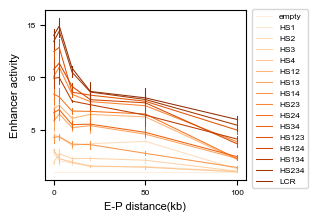

In [20]:
## Check enhancer activity of all library members across 6 distances (Figure 3B)
plt.figure(figsize=(2.6, 2.2))
sns.lineplot(merged_CREs, x="distance", y="norm_exp", hue="CRE", err_style="bars", hue_order=["empty", "HS1", "HS2", "HS3", "HS4", "HS12", "HS13", "HS14", "HS23", "HS24", "HS34", "HS123", "HS124", "HS134", "HS234", "LCR"], palette="Oranges", linewidth=0.75, err_kws={'elinewidth': 0.75})
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1.03), fontsize=6, ncol=1)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel("E-P distance(kb)", fontsize=8)
plt.ylabel("Enhancer activity", fontsize=8)
plt.savefig(figure_folder+"all_enhancers_curves.svg", dpi=300)

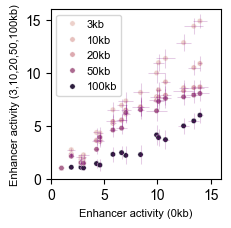

In [21]:
## Plot long-range activities against 0kb strength for all library members (Figure 3D)

merged_CREs_grouped = merged_CREs.groupby(["CRE","LP", "distance"])[["initial","norm_exp"]].mean().reset_index()
merged_CREs_grouped_err = merged_CREs.groupby(["CRE","LP", "distance"])[["initial", "norm_exp"]].std().reset_index()
merged_CREs_grouped = pd.merge(merged_CREs_grouped, merged_CREs_grouped_err, on=["CRE", "LP", "distance"])
merged_CREs_grouped.columns = ["CRE", "LP", "distance", "initial", "norm_exp", "initial_err", "norm_exp_err"]

plt.figure(figsize=(2.2, 2.2))
plt.errorbar(merged_CREs_grouped[merged_CREs_grouped["LP"].isin(["3kb", "10kb", "20kb", "50kb", "100kb"])]["initial"], merged_CREs_grouped[merged_CREs_grouped["LP"].isin(["3kb", "10kb",  "20kb", "50kb", "100kb"])]["norm_exp"], merged_CREs_grouped[merged_CREs_grouped["LP"].isin(["3kb", "10kb",  "20kb", "50kb", "100kb"])]["initial_err"],merged_CREs_grouped[merged_CREs_grouped["LP"].isin(["3kb", "10kb",  "20kb", "50kb", "100kb"])]["norm_exp_err"], ls="none", color="purple", alpha=0.2, linewidth=0.75)
sns.scatterplot(merged_CREs_grouped[merged_CREs_grouped["LP"].isin(["3kb", "10kb", "20kb", "50kb",  "100kb"])], x="initial", y="norm_exp", hue="distance", s=15)

# Update legend labels
legend_labels = ['3kb', '10kb',  "20kb", "50kb", '100kb']
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, legend_labels, fontsize=8, handletextpad=0.3)


plt.xlabel("Enhancer activity (0kb)", fontsize=8)
plt.ylabel("Enhancer activity (3,10,20,50,100kb)", fontsize=8)
plt.xlim(0,16)
plt.ylim(0,16)
plt.savefig(figure_folder+"activity_strength_all_distances.svg", dpi=300)

In [22]:
## Generate a colormap for distances

distance_6LP = {
    '0kb': "thistle", 
    '3kb': "violet",
    '10kb': "plum",
    '20kb': "purple",
    "50kb": "darkviolet",
    "100kb": "indigo"
}


In [23]:
## Calculate expected additive activities for HS combinations
merged_CREs.rename(columns={'LP': 'Distance', "norm_exp":"Fold change"}, inplace=True)
merged_CREs_grouped.rename(columns={'LP': 'Distance', "norm_exp":"Fold change"}, inplace=True)

distances = ["0kb", "10kb", "100kb"]
synergys = {}
additives = {}
for i in distances:
    elements = ["empty", "HS1", "HS2", "HS3", "HS4", "HS12", "HS13", "HS14", "HS23", "HS24", "HS34", "HS123", "HS124", "HS134", "HS234", "LCR"]
    activities = {x:merged_CREs_grouped.loc[((merged_CREs_grouped["CRE"] == x) & (merged_CREs_grouped["Distance"] == i)), "Fold change"].iloc[0] for x in elements}
    combinations = {"HS12":["HS1", "HS2"], "HS13":["HS1", "HS3"], "HS14":["HS1", "HS4"], "HS23":["HS2", "HS3"],"HS24":["HS2", "HS4"], "HS34":["HS3", "HS4"], "HS123":["HS1", "HS2", "HS3"], "HS124":["HS1", "HS2", "HS4"], "HS134":["HS1", "HS3", "HS4"], "HS234":["HS2", "HS3", "HS4"], "LCR":["HS1", "HS2", "HS3", "HS4"]}
    synergys[i] = {}
    additives[i] = {}
    for x in combinations:
        fragments = combinations[x]
        additive = 0
        n_frag = len(fragments)
        for y in fragments:
            additive += activities[y]
        additive = additive - n_frag+1
        real = activities[x]
        synergys[i][x] = real/additive
        additives[i][x] = additive

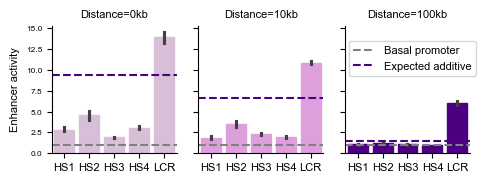

In [24]:
## Bar plots of individual HSs and LCR (Figure 3D)


g = sns.catplot(col = "Distance", data=merged_CREs, x="CRE", y="Fold change", order=["HS1", "HS2", "HS3", "HS4", "LCR"], col_order=["0kb", "10kb", "100kb"], legend=False, kind="bar", height=2.2, aspect=0.75)

for ax, col in zip(g.axes.flat, g.col_names):
    bars = ax.patches  # Get all bars in the current facet
    for bar in bars:
        bar.set_color(distance_6LP[col])  # Set color based on column
    ax.axhline(1, linestyle="--", color="grey", label="Basal activity")
    ax.axhline(additives[col]["LCR"], linestyle="--", color="indigo", label="Expected additive")
    ax.set_xlabel("")
    ax.set_ylabel("Enhancer activity", fontsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=6)
    ax.set_title(f"Distance={col}", fontsize=8)
# Add custom legend
custom_legend = [
    Line2D([0], [0], color="grey", linestyle="--", label="Basal promoter"),
    Line2D([0], [0], color="indigo", linestyle="--", label="Expected additive")
]
g.fig.legend(handles=custom_legend, loc="upper right", bbox_to_anchor=(0.99,0.8), ncol=1, fontsize=8)
plt.savefig(figure_folder+"LCR_synergy.svg", dpi=300)

pass

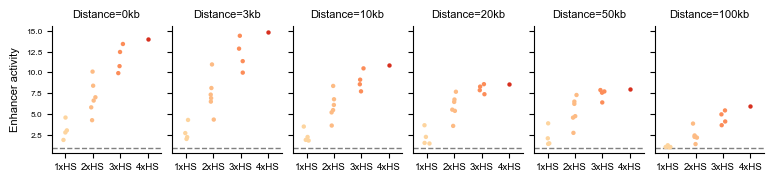

In [25]:
## Divide enhancers into groups based on the number of HSs (Figure 3C)
merged_CREs_grouped.loc[merged_CREs_grouped["CRE"].isin(["HS1", "HS2", "HS3", "HS4"]),"number of HSs"] = "1xHS"
merged_CREs_grouped.loc[merged_CREs_grouped["CRE"].isin(["HS12", "HS13", "HS14", "HS23", "HS24", "HS34"]),"number of HSs"] = "2xHS"
merged_CREs_grouped.loc[merged_CREs_grouped["CRE"].isin(["HS123", "HS124", "HS134", "HS234"]),"number of HSs"] = "3xHS"
merged_CREs_grouped.loc[merged_CREs_grouped["CRE"].isin(["LCR"]),"number of HSs"] = "4xHS"

merged_CREs_grouped.columns = ["CRE", "Distance", "distance", "initial", "Fold change", "initial_err", "norm_exp_err", "number of HSs"]

grouped_palette = {
    "1xHS": "#fdd49e",  # soft peach
    "2xHS": "#fdbb84",  # warm orange
    "3xHS": "#fc8d59",  # bold coral-orange
    "4xHS": "#d7301f"   # strong reddish orange
}

g = sns.catplot(data = merged_CREs_grouped, x="number of HSs", hue="number of HSs", col="Distance", y="Fold change", order=["1xHS", "2xHS", "3xHS", "4xHS"], col_order=["0kb", "3kb", "10kb", "20kb", "50kb", "100kb"], height=2.2, aspect=0.6, s=10, palette=grouped_palette, legend=False)
g.map(plt.axhline, y=1, ls='--', color='grey', linewidth=1)

g.fig.subplots_adjust(wspace=0.1)

for ax, col in zip(g.axes.flat, g.col_names):
    ax.set_xlabel("")
    ax.set_ylabel("Enhancer activity", fontsize=8)
    ax.tick_params(axis="x", labelsize=7)
    ax.tick_params(axis="y", labelsize=6)
    ax.set_title(f"Distance={col}", fontsize=8)
plt.savefig(figure_folder+"cooperativity_among_enhancers.svg", dpi=300)